### Stable Diffusion 2 (impainting)

In [1]:
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler
import torch 
import numpy as np
from PIL import Image

from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
img_size = 512
border = 100
background_color = 255

# Starting image is a square on white bg
booth = np.ones((img_size, img_size,3))*background_color
booth[border:img_size-border,border:img_size-border,:] = 0
booth = Image.fromarray(booth.astype(np.uint8()))

mask = np.zeros((img_size,img_size,3))
mask[border:img_size-border,border:img_size-border,:] = 255
mask = Image.fromarray(mask.astype(np.uint8()))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

prompt = "a blue coffee mug"
prompt_details = ", full body centered camera view, blender render, high resolution, standard light, no reflections"

generated_image = pipe(prompt=prompt + prompt_details, image=booth, mask_image=mask).images[0]

text_encoder\model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

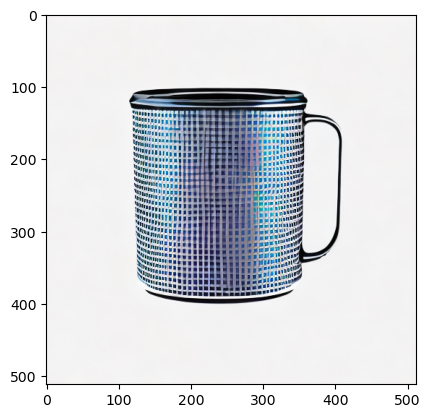

In [4]:
plt.imshow(generated_image)

### 3DiM

In [5]:
from xunet import XUNet

from random import randrange
import torch
import torch.nn.functional as F

from tqdm import tqdm
from einops import rearrange
import time

from SRNdataset import dataset, MultiEpochsDataLoader
from tensorboardX import SummaryWriter
import os
import glob
from PIL import Image
import random

In [6]:
def logsnr_schedule_cosine(t, *, logsnr_min=-20., logsnr_max=20.):
    b = np.arctan(np.exp(-.5 * logsnr_max))
    a = np.arctan(np.exp(-.5 * logsnr_min)) - b
    
    return -2. * torch.log(torch.tan(a * t + b))

def xt2batch(x, logsnr, z, R, T, K):
    b = x.shape[0]
    

    return {
        'x': x.cuda(),
        'z': z.cuda(),
        'logsnr': torch.stack([logsnr_schedule_cosine(torch.zeros_like(logsnr)), logsnr], dim=1).cuda(),
        'R': R.cuda(),
        't': T.cuda(),
        'K':K[None].repeat(b,1,1).cuda(),
    }

# ----------------------- Diffusion forward process -----------------------

@torch.no_grad()
def sample(model, record, target_R, target_T, K, w, timesteps=256):
    """
        Forward process
    """
    b = w.shape[0]
    img = torch.randn_like(torch.tensor(record[0][0]))
    
    logsnrs = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[:-1])
    logsnr_nexts = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[1:])
    
    for logsnr, logsnr_next in tqdm(zip(logsnrs, logsnr_nexts), total=len(logsnrs), desc='diffusion loop', position=1, leave=False): # [1, ..., 0] = size is 257
        condition_img, condition_R, condition_T = random.choice(record)
        condition_img = torch.tensor(condition_img)
        condition_R = torch.tensor(condition_R)
        condition_T = torch.tensor(condition_T)
        
        R = torch.stack([condition_R, target_R], 0)[None].repeat(b, 1, 1, 1)
        T = torch.stack([condition_T, target_T], 0)[None].repeat(b, 1, 1)
        condition_img = condition_img
        img = p_sample(model,
                       z=img,
                       x=condition_img, 
                       R=R,
                       T=T,
                       K=K,
                       logsnr=logsnr, logsnr_next=logsnr_next,
                       w=w)
        
    return img.cpu().numpy()

def q_sample(z, logsnr, noise):
    """
        Forward: q(x_t|x_0)
    """
    # lambdas = logsnr_schedule_cosine(t)
    
    alpha = logsnr.sigmoid().sqrt()
    sigma = (-logsnr).sigmoid().sqrt()
    
    alpha = alpha[:,None, None, None]
    sigma = sigma[:,None, None, None]

    return alpha * z + sigma * noise


# ----------------------- Diffusion backward process -----------------------

@torch.no_grad()
def p_sample(model, x, z, R, T, K, logsnr, logsnr_next, w):
    """
        Backward process: epsilon_0(x_t, t)
    """
    
    model_mean, model_variance = p_mean_variance(model, x=x, z=z, R=R, T=T, K=K, logsnr=logsnr, logsnr_next=logsnr_next, w=w)
    
    if logsnr_next==0:
        return model_mean
    
    return model_mean + model_variance.sqrt() * torch.randn_like(x).cpu()


@torch.no_grad()
def p_mean_variance(model, x, z, R, T, K, logsnr, logsnr_next, w=2.0):
    """
        Backward process (and variance)
    """
    
    strt = time.time()
    b = x.shape[0]
    w = w[:, None, None, None]
    
    c = - torch.special.expm1(logsnr - logsnr_next)

    squared_alpha, squared_alpha_next = logsnr.sigmoid(), logsnr_next.sigmoid()
    squared_sigma, squared_sigma_next = (-logsnr).sigmoid(), (-logsnr_next).sigmoid()
    
    alpha, sigma, alpha_next = map(lambda x: x.sqrt(), (squared_alpha, squared_sigma, squared_alpha_next))
    
    # batch = xt2batch(x, logsnr.repeat(b), z, R)
    batch = xt2batch(x, logsnr.repeat(b), z, R, T, K)
    
    strt = time.time()

    # Predicted noise
    pred_noise = model(batch, cond_mask= torch.tensor([True]*b)).detach().cpu()
    batch['x'] = torch.randn_like(x).cuda()
    pred_noise_unconditioned = model(batch, cond_mask= torch.tensor([False]*b)).detach().cpu()
    
    pred_noise_final = (1+w) * pred_noise - w * pred_noise_unconditioned
    
    z = z.detach().cpu()
    
    # actual predicted x_0
    z_start = (z - sigma * pred_noise_final) / alpha
    z_start.clamp_(-1., 1.)
    
    model_mean = alpha_next * (z * (1 - c) / alpha + c * z_start)
    
    posterior_variance = squared_sigma_next * c
    
    return model_mean, posterior_variance


def p_losses(denoise_model, img, R, T, K, logsnr, noise=None, loss_type="l2", cond_prob=0.1):
    """
        Backward process loss: E[|| epsilon - epsilon_0(x_t, t)||]
    """
    B = img.shape[0]
    x = img[:, 0]
    z = img[:, 1]
    if noise is None:
        noise = torch.randn_like(x)

    z_noisy = q_sample(z=z, logsnr=logsnr, noise=noise)
    
    
    cond_mask = (torch.rand((B,)) > cond_prob).cuda()
    
    x_condition = torch.where(cond_mask[:, None, None, None], x, torch.randn_like(x))
    
    batch = xt2batch(x=x_condition, logsnr=logsnr, z=z_noisy, R=R, T=T, K=K)
    
    predicted_noise = denoise_model(batch, cond_mask=cond_mask.cuda())

    if loss_type == 'l1':
        loss = F.l1_loss(noise.to(device), predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise.to(device), predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise.to(device), predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
imgsize = 64

# Model
pretrained_model = "trained_model.pt"
model = XUNet(H=imgsize, W=imgsize, ch=128)
model = torch.nn.DataParallel(model)
model.to('cuda')

ckpt = torch.load(pretrained_model)
model.load_state_dict(ckpt['model'])

In [ ]:
data_imgs = []

# Loading generated frame
img = generated_image.resize((imgsize, imgsize))
img = np.array(img) / 255 * 2 - 1

img = img.transpose(2,0,1)[:3].astype(np.float32)
data_imgs.append(img)

In [ ]:
data_Rs = []
data_Ts = []

# [single example] Take a random example, a random view and its relative pose 
dataset = "./cars_train_val/"
train_examples = [ f.path for f in os.scandir(dataset) if f.is_dir() ]
train_example = train_examples[randrange(len(train_examples))]
train_example_idx = randrange(10)

pose_filename = os.path.join(train_example, 'pose', "{:06d}.txt".format(train_example_idx))
pose = np.array(open(pose_filename).read().strip().split()).astype(float).reshape((4,4))

data_Rs.append(pose[:3, :3])
data_Ts.append(pose[:3, 3])

data_K = np.array(open(os.path.join(train_example, 'intrinsics', "{:06d}.txt".format(train_example_idx))).read().strip().split()).astype(float).reshape((3,3))
data_K = torch.tensor(data_K)

In [ ]:
# Input image(s)
w = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7])
b = w.shape[0]
record = [[data_imgs[0][None].repeat(b, axis=0), 
           data_Rs[0],
           data_Ts[0]]]

# Straight sampling, given one example of images (data_imgs)
with torch.no_grad():
    step = 1
    start_idx = 0
    for gt, R, T in tqdm(zip(data_imgs[start_idx:], data_Rs[start_idx:], data_Ts[start_idx:]), total=len(data_imgs[start_idx:]), desc='view loop', position=0):
        
        R = torch.tensor(R)
        T = torch.tensor(T)

        img = sample(model, record=record, target_R=R, target_T=T, K=data_K, w=w)

        record.append([img, R.cpu().numpy(), T.cpu().numpy()])

        for i in w:
            generated_view = ((img[i].transpose(1,2,0)+1)*127.5).astype(np.uint8)
            plt.imshow(generated_view)
            #Image.fromarray().save(f'sampling/{step}/{i}.png')
        
        step += 1